In [1]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import ipdb
import re
import csv
import datetime as dt
from copy import deepcopy
from glob import glob
import ast
from collections import Counter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.core.debugger import set_trace
from difflib import SequenceMatcher

from scipy.stats import pearsonr, spearmanr
from nltk.corpus import words
word_list = words.words()

import matplotlib.pyplot as plt
# import mplcursors
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(15,10), 'font.family': 'Times'})

tqdm.pandas()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('chained_assignment',None)

# Set random seeds for reproducibility on a specific machine
random.seed(1)
np.random.seed(1)
np.random.RandomState(1)

RandomState(MT19937) at 0x10398F140

In [2]:
test = pd.read_csv('../data/test_data.tsv', sep='\t', quoting=csv.QUOTE_NONE, escapechar="\\")
test.ref_expressions = test.ref_expressions.apply(lambda x: eval(x))

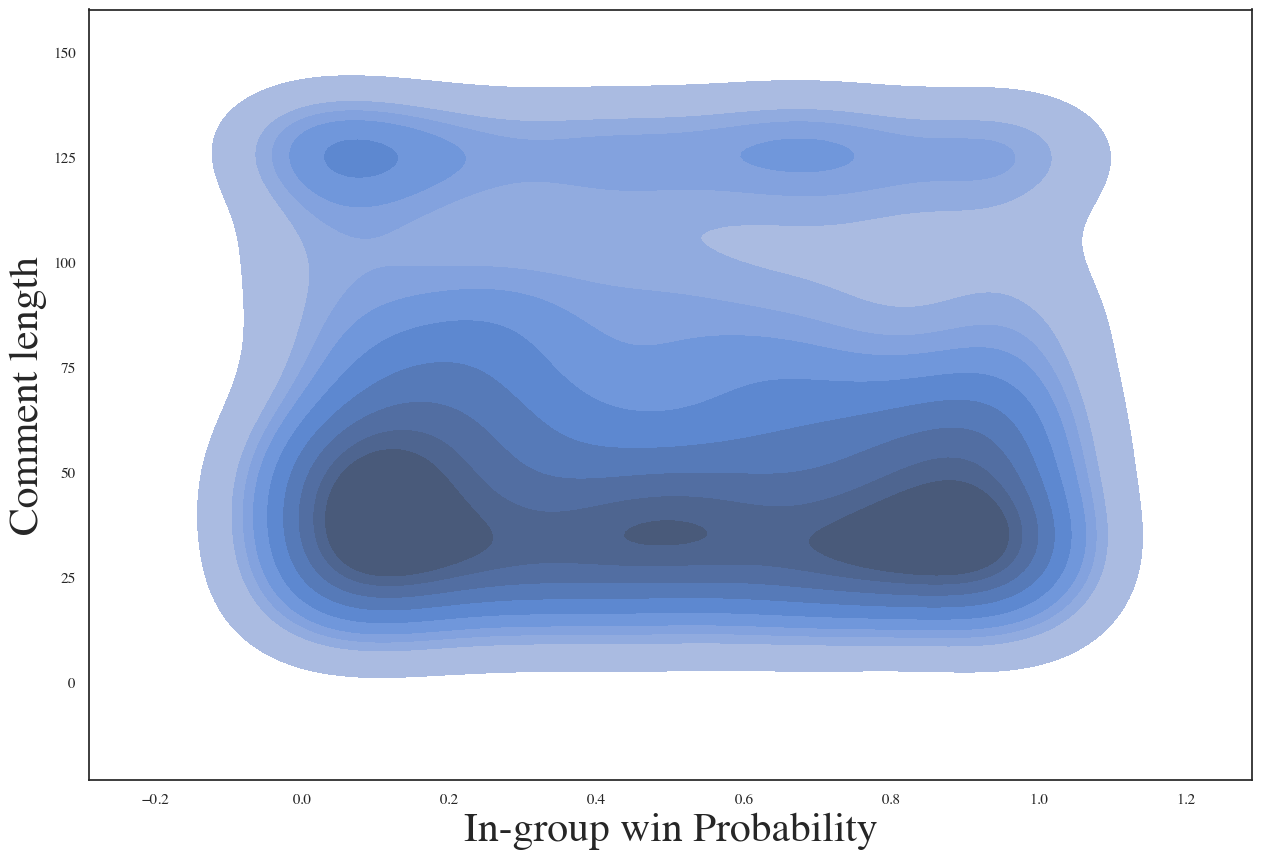

In [3]:
test['len'] = test.tokenized_comment.apply(lambda x: len(x))
test.loc[test.len>128, 'len'] = 128
g = sns.kdeplot(x=test.win_prob, y=test.len, fill=True)
g.set_xlabel('In-group win Probability',fontsize=30)
g.set_ylabel('Comment length',fontsize=30)
g.set_title('')
g.spines["top"].set_visible(True)
g.spines["right"].set_visible(True)
plt.show()

In [4]:
spearmanr(test.win_prob.values, test.len.values)

SignificanceResult(statistic=-0.03406161120822453, pvalue=0.18748923803435152)

In [5]:
pearsonr(test.win_prob.values, test.len.values)

PearsonRResult(statistic=-0.03623031556300455, pvalue=0.16091035020115044)

In [6]:
postinfo = pd.read_csv('../data/postInfo.tsv', sep='\t')
gameinfo = pd.read_csv('../data/gameInfo.tsv', sep='\t')
teaminfo = pd.read_csv('../data/nfl_teams.csv')

teaminfo['team_name_short'] = teaminfo['team_name_short'].apply(lambda x: x.lower())

teams = teaminfo['team_name_short'].values.tolist()
subreddits = teaminfo['subreddit'].values.tolist()

teams_to_subreddit = {teams[i]: subreddits[i] for i in range(32)}
subreddit_to_teams = {subreddits[i]: teams[i] for i in range(32)}
team_names_dict = {x: [x] for x in teams}

for x in teams:
    team_id_word = teaminfo[teaminfo['team_name_short']==x]['team_id'].values[0]
    if team_id_word not in word_list:
        team_names_dict[x].append(team_id_word)
    
    team_id_pfr = teaminfo[teaminfo['team_name_short']==x]['team_id_pfr'].values[0]
    if team_id_pfr not in word_list:
        team_names_dict[x].append(team_id_pfr)
    
    # get approx location name? There will be overlaps
    city_name = teaminfo[teaminfo['team_name_short']==x]['team_name'].values[0].replace(x,'').strip()
    if city_name not in word_list:
        team_names_dict[x].append(city_name)
    team_names_dict[x] = list(set(team_names_dict[x]))

team_names_dict['jaguars'] += ['jag', 'cardiac jag', 'cardiac jaguar']
team_names_dict['patriots']+= ['pat', 'patsie', 'deflatriot', 'cheatriot', 'empire']
team_names_dict['colts'] += ['dolt']
team_names_dict['dolphins'] += ['fin', 'phin', 'fish']
team_names_dict['cardinals'] += ['card', 'cardiac card', 'cardiac cardinal']
team_names_dict['saints'] += ['aint', 'aint\'', 'sinner']
team_names_dict['lions'] += ['cardiac cat']
team_names_dict['falcons'] += ['dirty bird', 'bird']
team_names_dict['ravens'] += ['purple', 'purple murder']
team_names_dict['panthers'] += ['cardiac cat']
team_names_dict['bears'] += ['dabear', 'da bear']
team_names_dict['packers'] += ['cheesehead', 'the pack', 'gang green']
team_names_dict['texans'] += ['no-win']
team_names_dict['chiefs'] += ['chef']
team_names_dict['raiders'] += ['da raidah', 'fader', 'traitor', 'jokeland', 'silver and black']
team_names_dict['chargers'] += ['bolt']
team_names_dict['rams'] += ['goat', 'lamb']
team_names_dict['vikings'] += ['vike']
team_names_dict['giants'] += ['g-men', 'jint', 'big blue', 'wrecking crew', 'blue giant']
team_names_dict['jets'] += ['gang green', 'jest']
team_names_dict['eagles'] += ['iggle']
team_names_dict['steelers'] += ['stiller']
team_names_dict['49ers'] += ['whiner', 'forty-whiner', 'niner']
team_names_dict['seahawks'] += ['seagull']
team_names_dict['buccaneers'] += ['buc', 'buckie']
team_names_dict['titans'] += ['oiler', 'flaming thumbtack', 'titanic', 'traitor']
team_names_dict['commanders'] += ['deadskin', 'chesapeake watershed region indigenous person', 'potomac drainage basin indigenous person', 'skin']
team_names_dict['bills'] += ['b.i.l.l.s']
team_names_dict['bengals'] += ['bungles']
team_names_dict['browns'] += ['clown', 'dawg']
team_names_dict['cowboys'] += ['empire', 'americas team', 'america\'s team', 'cowgirl']
team_names_dict['broncos'] += ['donk']

team_names_dict['washington'] = team_names_dict['commanders']

In [7]:
test['we'] = test['ref_expressions'].apply(lambda x: len(re.findall(r'\b(we)(\'re|\'ll|\'d)?|us\b', ' '.join(x), flags=re.IGNORECASE)))

test['[in]'] = test['tagged_comment'].apply(lambda x: x.count('[IN]'))
test['out'] = test['tagged_comment'].apply(lambda x: x.count('[OUT]'))
test['other'] = test['tagged_comment'].apply(lambda x: x.count('[OTHER]'))
test['sent'] = test['ref_expressions'].apply(lambda x: sum([1 if 'SENT' in y else 0 for y in x]))

def count_nicks(row, teamname):
    regex = r'\b(' + '|'.join([re.escape(name) for name in team_names_dict[teamname]]) + r')(s)?\b'
    
    return len(re.findall(regex, ' '.join(row.ref_expressions), flags=re.IGNORECASE))

test['in_nicks'] = test.apply(lambda row: count_nicks(row, row.team), axis=1)
test['out_nicks'] = test.apply(lambda row: count_nicks(row, row.opp), axis=1)

test['[any]'] = test.ref_expressions.apply(lambda x: len(x))

test['none'] = test.ref_expressions.apply(lambda x: 1 if len(x)==0 else 0)

In [8]:
np.round(test.none.sum()/test.shape[0], 2)

0.27

In [9]:
def find_they(ref_expressions, tags, group):
    length = min(len(ref_expressions), len(tags))
    count = 0
    for i in range(length):
        if tags[i]==group and len(re.findall(r'\b((they)(\'re|\'ll|\'d)?|them|(their\s(off|def)(.*)?))\b', ref_expressions[i], flags=re.IGNORECASE))>0:
            count += 1
    return count

test['they_in'] = test.apply(lambda row: find_they(row.ref_expressions, row.ref_tags, '[IN]'), axis=1)
test['they_out'] = test.apply(lambda row: find_they(row.ref_expressions, row.ref_tags, '[OUT]'), axis=1)
test['they_other'] = test.apply(lambda row: find_they(row.ref_expressions, row.ref_tags, '[OTHER]'), axis=1)

In [10]:
all_df = {}

for variable in ['we', '[in]', 'out', 'other', 'sent', '[any]', 'in_nicks', 'out_nicks', 'they_in', 'they_out', 'they_other', 'none']:
    all_df[variable] = []
    for max_p in range(5,101,5):
        max_prob = float(max_p/100)
        min_prob = float((max_p-5)/100)
        if max_p==5:
            num_comm = test[((test['win_prob']<=max_prob) & (test['win_prob']>=min_prob))].shape[0]
            num_rel_comm = test[((test['win_prob']<=max_prob) & (test['win_prob']>=min_prob))][variable].sum()
        else:
            num_comm = test[((test['win_prob']<=max_prob) & (test['win_prob']>min_prob))].shape[0]
            num_rel_comm = test[((test['win_prob']<=max_prob) & (test['win_prob']>min_prob))][variable].sum()
        all_df[variable].append(num_rel_comm/num_comm)

all_df['win-prob'] = [(x-2.5) for x in range(5, 101, 5)]
all_df = pd.melt(pd.DataFrame(all_df), id_vars='win-prob')

# with sns.plotting_context(font_scale=1):
#     g = sns.lmplot(all_df[all_df.variable.isin(['we', 'out', 'other'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
#     g.fig..set_xlabel('In-group win Probability',fontsize=30)
#     g.fig..set_ylabel('')
#     g.fig..set_title('Frequency of variable across win probabilities.',fontsize=30)
#     g.fig..legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
#     plt.show()

# with sns.plotting_context(font_scale=1):
#     g = sns.lmplot(all_df[all_df.variable.isin(['in_nicks', 'out_nicks'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, robust=True)
#     g.fig..set_xlabel('In-group win Probability',fontsize=30)
#     g.fig..set_ylabel('')
#     g.fig..set_title('Frequency of variable across win probabilities.',fontsize=30)
#     g.fig..legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
#     plt.show()
    
# with sns.plotting_context(font_scale=1):
#     g = sns.lmplot(all_df[all_df.variable.isin(['in', 'any_ref'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
#     g.fig..set_xlabel('In-group win Probability',fontsize=30)
#     g.fig..set_ylabel('')
#     g.fig..set_title('Frequency of variable across win probabilities.',fontsize=30)
#     g.fig..legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
#     plt.show()

# with sns.plotting_context(font_scale=1):
#     g = sns.lmplot(all_df[all_df.variable.isin(['sent'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
#     g.fig..set_xlabel('In-group win Probability',fontsize=30)
#     g.fig..set_ylabel('')
#     g.fig..set_title('Frequency of variable across win probabilities.',fontsize=30)
#     g.fig..legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
#     plt.show()
    
# with sns.plotting_context(font_scale=1):
#     g = sns.lmplot(all_df[all_df.variable.isin(['they_in','they_out', 'they_other'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
#     g.fig..set_xlabel('In-group win Probability',fontsize=30)
#     g.fig..set_ylabel('')
#     g.fig..set_title('Frequency of variable across win probabilities.',fontsize=30)
#     g.fig..legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
#     plt.show()

# with sns.plotting_context(font_scale=1):
#     g = sns.lmplot(all_df[all_df.variable.isin(['none'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.7, legend=False, scatter_kws={'s': 100}, order=1)
#     g.fig..set_xlabel('In-group win Probability',fontsize=30)
#     g.fig..set_ylabel('')
#     g.fig..set_title('Frequency of variable across win probabilities.',fontsize=30)
#     g.fig..legend(loc='lower center', ncol=4, bbox_to_anchor=(.5, -0.3),fontsize=30) 
#     plt.show()

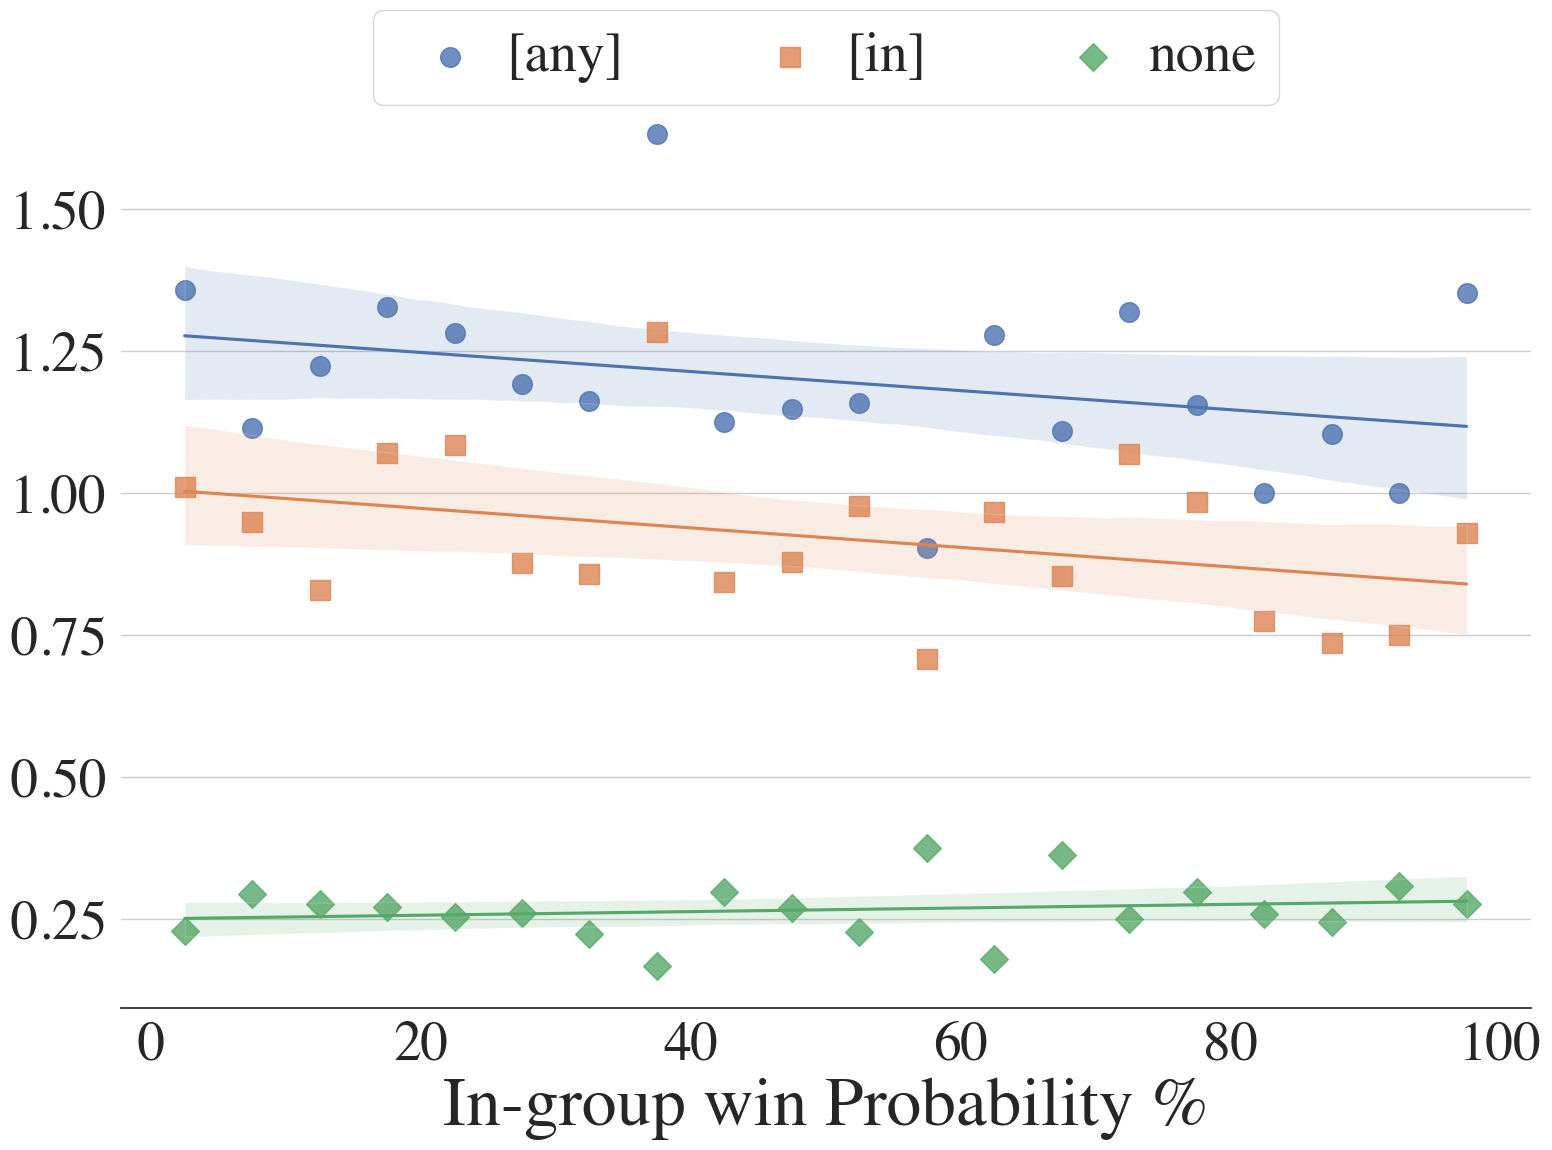

In [11]:
with sns.plotting_context(font_scale=1):
    g = sns.lmplot(all_df[all_df.variable.isin(['[any]', '[in]', 'none'])], x='win-prob', y='value', hue='variable', height=10, aspect=1.5, legend=False, scatter_kws={'s': 200}, markers=['o', 's', 'D' ], hue_order=['[any]', '[in]', 'none'], order=1)
    g.fig.get_axes()[0].set_xlabel('In-group win Probability %',fontsize=50)
    g.fig.get_axes()[0].set_ylabel('')
    g.fig.get_axes()[0].set_title('')
    g.fig.get_axes()[0].tick_params(axis='x', labelsize=40)
    g.fig.get_axes()[0].tick_params(axis='y', labelsize=40)
    g.fig.get_axes()[0].legend(loc='upper center', ncol=5, bbox_to_anchor=(.5, 1.12),fontsize=40, handletextpad=0.001, frameon=True) 
    g.fig.get_axes()[0].spines["top"].set_visible(False)
    g.fig.get_axes()[0].spines["right"].set_visible(False)
    g.fig.get_axes()[0].spines["left"].set_visible(False)
    g.fig.get_axes()[0].grid(axis='y')

# plt.savefig('/Users/venkat/Desktop/EMNLP/figures/gold-trends.pdf', bbox_inches='tight', transparent=True)

In [12]:
# all_df[all_df.variable=='any_ref'].loc[:, ['win-prob', 'value']].to_csv('/Users/venkat/Desktop/thesis/data/test-trends-all.tsv', index=False, sep='\t')

In [19]:
ids = test['username'].unique()
d = dict(zip(ids, np.random.choice(range(2000), size=len(ids), replace=False)))
test['username_anon'] = test['username'].map(d)

In [21]:
test.loc[:, ['split', 'post_id', 'comment_id', 'parent_id', 'username_anon', 'tagged_comment', 'ref_expressions', 'ref_pos', 'ref_tags', 'explanation', 'explanation+wp', 'timestamp', 'team', 'opp', 'win_prob', 'confs']].to_csv('../data/gold_data.tsv', sep='\t', quoting=csv.QUOTE_NONE, escapechar="\\", index=None)